<a href="https://colab.research.google.com/github/Tony14100/portfolio/blob/main/%22%D0%92%D0%B5%D1%80%D0%BE%D1%8F%D1%82%D0%BD%D0%BE%D1%81%D1%82%D0%BD%D0%BE%D0%B5_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BF%D0%B0%D0%BA%D0%B5%D1%82%D0%B0_AutoBNN%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом блокноте представлен пакет Tensorflow Probability AutoBNN. В нем приведены примеры прогнозирования с использованием набора данных об атмосферном CO2 на Мауна-Лоа с использованием либо изученных, либо заданных вручную ядер.

In [ ]:
!pip install autobnn

import jax
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

from autobnn import estimators
from autobnn import operators
from autobnn import kernels
from autobnn import likelihoods
from autobnn import training_util

seed = jax.random.PRNGKey(0)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 7.7 MB/s eta 0:00:00
  Created wheel for autobnn: filename=autobnn-0.0.2.dev0-py3-none-any.whl size=42693 sha256=0e850957cac8771b9eb05ef16c10be61ba05d616eab921b536400

Данные по CO2 в Мауна-Лоа
Набор данных по атмосферному CO2 в Мауна-Лоа доступен для скачивания в Институте Скриппса. Мы создаем базу данных Pandas с ежемесячными данными о концентрации CO2, что позволяет прогнозировать последние 10 лет.

In [ ]:
# The Mauna Loa data as taken from
# https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv
# Data is provided by the Scripps Institution of Oceanography at UC San Diego under a CC BY license
# (https://creativecommons.org/licenses/by/4.0/).
co2_by_month = np.array('320.62,321.60,322.39,323.70,324.08,323.75,322.38,320.36,318.64,318.10,319.78,321.03,322.33,322.50,323.04,324.42,325.00,324.09,322.54,320.92,319.25,319.39,320.73,321.96,322.57,323.15,323.89,325.02,325.57,325.36,324.14,322.11,320.33,320.25,321.32,322.89,324.00,324.42,325.63,326.66,327.38,326.71,325.88,323.66,322.38,321.78,322.85,324.12,325.06,325.98,326.93,328.14,328.08,327.67,326.34,324.69,323.10,323.06,324.01,325.13,326.17,326.68,327.17,327.79,328.92,328.57,327.36,325.43,323.36,323.56,324.80,326.01,326.77,327.63,327.75,329.73,330.07,329.09,328.04,326.32,324.84,325.20,326.50,327.55,328.55,329.56,330.30,331.50,332.48,332.07,330.87,329.31,327.51,327.18,328.16,328.64,329.35,330.71,331.48,332.65,333.09,332.25,331.18,329.39,327.43,327.37,328.46,329.57,330.40,331.40,332.04,333.31,333.97,333.60,331.90,330.06,328.56,328.34,329.49,330.76,331.75,332.56,333.50,334.58,334.88,334.33,333.05,330.94,329.30,328.94,330.31,331.68,332.93,333.42,334.70,336.07,336.75,336.27,334.92,332.75,331.59,331.16,332.40,333.85,334.97,335.38,336.64,337.76,338.01,337.89,336.54,334.68,332.76,332.55,333.92,334.95,336.23,336.76,337.96,338.88,339.47,339.29,337.73,336.09,333.92,333.86,335.29,336.73,338.01,338.36,340.07,340.77,341.47,341.17,339.56,337.60,335.88,336.02,337.10,338.21,339.24,340.48,341.38,342.51,342.91,342.25,340.49,338.43,336.69,336.86,338.36,339.61,340.75,341.61,342.70,343.57,344.14,343.35,342.06,339.81,337.98,337.86,339.26,340.49,341.38,342.52,343.10,344.94,345.76,345.32,343.98,342.38,339.87,339.99,341.15,342.99,343.70,344.50,345.28,347.06,347.43,346.80,345.39,343.28,341.07,341.35,342.98,344.22,344.97,345.99,347.42,348.35,348.93,348.25,346.56,344.67,343.09,342.80,344.24,345.56,346.30,346.95,347.85,349.55,350.21,349.55,347.94,345.90,344.85,344.17,345.66,346.90,348.02,348.48,349.42,350.99,351.85,351.26,349.51,348.10,346.45,346.36,347.81,348.96,350.43,351.73,352.22,353.59,354.22,353.79,352.38,350.43,348.73,348.88,350.07,351.34,352.76,353.07,353.68,355.42,355.67,355.12,353.90,351.67,349.80,349.99,351.30,352.52,353.66,354.70,355.38,356.20,357.16,356.23,354.81,352.91,350.96,351.18,352.83,354.21,354.72,355.75,357.16,358.60,359.34,358.24,356.17,354.02,352.15,352.21,353.75,354.99,355.99,356.72,357.81,359.15,359.66,359.25,357.02,355.00,353.01,353.31,354.16,355.40,356.70,357.17,358.38,359.46,360.28,359.60,357.57,355.52,353.69,353.99,355.34,356.80,358.37,358.91,359.97,361.26,361.69,360.94,359.55,357.48,355.84,356.00,357.58,359.04,359.97,361.00,361.64,363.45,363.80,363.26,361.89,359.45,358.05,357.75,359.56,360.70,362.05,363.24,364.02,364.71,365.41,364.97,363.65,361.48,359.45,359.61,360.76,362.33,363.18,363.99,364.56,366.36,366.80,365.63,364.47,362.50,360.19,360.78,362.43,364.28,365.33,366.15,367.31,368.61,369.30,368.88,367.64,365.78,363.90,364.23,365.46,366.97,368.15,368.87,369.59,371.14,371.00,370.35,369.27,366.93,364.64,365.13,366.68,368.00,369.14,369.46,370.51,371.66,371.83,371.69,370.12,368.12,366.62,366.73,368.29,369.53,370.28,371.50,372.12,372.86,374.02,373.31,371.62,369.55,367.96,368.09,369.68,371.24,372.44,373.08,373.52,374.85,375.55,375.40,374.02,371.48,370.70,370.25,372.08,373.78,374.68,375.62,376.11,377.65,378.35,378.13,376.61,374.48,372.98,373.00,374.35,375.69,376.79,377.36,378.39,380.50,380.62,379.55,377.76,375.83,374.05,374.22,375.84,377.44,378.34,379.61,380.08,382.05,382.24,382.08,380.67,378.67,376.42,376.80,378.31,379.96,381.37,382.02,382.56,384.37,384.92,384.03,382.28,380.48,378.81,379.06,380.14,381.66,382.58,383.71,384.34,386.23,386.41,385.87,384.45,381.84,380.86,380.86,382.36,383.61,385.07,385.84,385.83,386.77,388.51,388.05,386.25,384.08,383.09,382.78,384.01,385.11,386.65,387.12,388.52,389.57,390.16,389.62,388.07,386.08,384.65,384.33,386.05,387.49,388.55,390.07,391.01,392.38,393.22,392.24,390.33,388.52,386.84,387.16,388.67,389.81,391.30,391.92,392.45,393.37,394.28,393.69,392.59,390.21,389.00,388.93,390.24,391.80,393.07,393.35,394.36,396.43,396.87,395.88,394.52,392.54,391.13,391.01,392.95,394.34,395.61,396.85,397.26,398.35,399.98,398.87,397.37,395.41,393.39,393.70,395.19,396.82,397.92,398.10,399.47,401.33,401.88,401.31,399.07,397.21,395.40,395.65,397.23,398.79,399.85,400.31,401.51,403.45,404.10,402.88,401.61,399.00,397.50,398.28,400.24,401.89,402.65,404.16,404.85,407.57,407.66,407.00,404.50,402.24,401.01,401.50,403.64,404.55,406.07,406.64,407.06,408.95,409.91,409.12,407.20,405.24,403.27,403.64,405.17,406.75,408.05,408.34,409.25,410.30,411.30,410.88,408.90,407.10,405.59,405.99,408.12,409.23,410.92'.split(',')).astype(np.float32)
num_forecast_steps = 12 * 10 # Forecast the final ten years, given previous data
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]

co2_dates = np.arange("1966-01", "2019-02", dtype="datetime64[M]")

Text(0, 0.5, 'CO2 concentration / ppm')

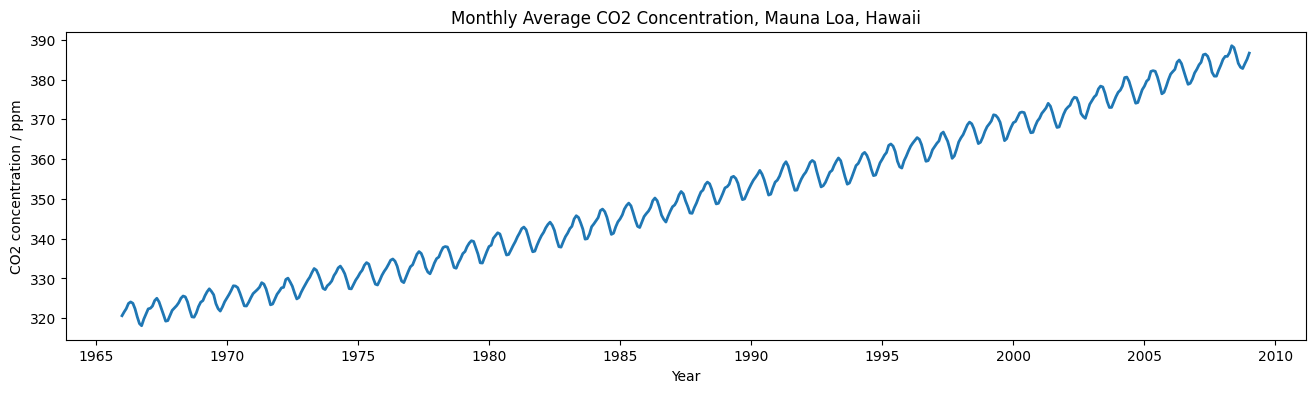

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(co2_dates[:-num_forecast_steps], co2_by_month_training_data, lw=2)
plt.title("Monthly Average CO2 Concentration, Mauna Loa, Hawaii")
plt.xlabel("Year")
plt.ylabel("CO2 concentration / ppm")

Данные передаются в функцию подгонки в виде массива временных индексов x_train (нормализованных для охвата диапазона от 0 до 1), которые формируют входные данные для нейронной сети, и массива целевых значений y_train, которые сеть прогнозирует.

In [ ]:
x_test = np.arange(len(co2_by_month), dtype=np.float32)
y_test = co2_by_month
x_train = x_test[:-num_forecast_steps]
y_train = co2_by_month_training_data

x_scale = x_train.max()
x_train = x_train / x_scale
x_test = x_test / x_scale

one_year = jnp.array(12. / x_scale, dtype=jnp.float32)  # monthly data

Моделирование с помощью ядра GP, созданного вручную
В этом разделе рассматривается применение фреймворка AutoBNN с ядром, созданным вручную, на примере, приведенном в разделе 5.4.3 работы Rasmussen & Williams (2006), для моделирования набора данных по атмосферному CO2 на Мауна-Лоа. Их пример призван продемонстрировать мощь и гибкость гауссовских процессов, а выбранное ими ядро служит ценным тестовым примером для нашей платформы.

Расмуссен и Уильямс выбрали следующие компоненты для своей модели:

ядро с квадратичной экспонентой (SE), чтобы зафиксировать плавный тренд.
периодическое ядро с периодом в один год, умноженное на SE, чтобы допускать отклонения от точной периодичности.
рациональная квадратичная величина для моделирования среднесрочных нарушений.
экспоненциальный шум в квадрате.
Авторы отмечают, что "можно было бы также использовать квадратичную экспоненциальную форму для [рациональной квадратичной] составляющей", что мы и делаем здесь, поскольку наша структура в настоящее время не реализует рациональную квадратичную форму. Квадратичный экспоненциальный шумовой термин предусмотрен нашей нормой

In [ ]:
smooth_trend = kernels.ExponentiatedQuadraticBNN(
    amplitude_scale=4., length_scale_scale=one_year * 4.)

# For annoying technical reasons, any kernels used in a Multiply operator
# must pass the going_to_be_multiplied=True option in their constructor.
# (This is because the Multiply operator doesn't use the final layer of
# weights from its input BNNs, and going_to_be_multiplied=True tells the
# BNN not to create them so that they are not allocated or optimized over.)
seasonal = operators.Multiply(bnns=[
    kernels.PeriodicBNN(period=one_year, going_to_be_multiplied=True),
    kernels.ExponentiatedQuadraticBNN(amplitude_scale=4.,
                                      length_scale_scale=one_year,
                                      going_to_be_multiplied=True)])

medium_term = kernels.ExponentiatedQuadraticBNN(length_scale_scale=one_year)

# To train a BNN, we must define a likelihood model that says how likely
# the observed data is given the BNN's predictions.  The
# NormalLikelihoodLogisticNoise likelihood model says that
# P(data | predictions) ~ N(mean=predictions, scale=n)
# with
# n ~ Logistic(location=0, scale=log_noise_scale)
likelihood = likelihoods.NormalLikelihoodLogisticNoise(log_noise_scale=0.1)

kernel = operators.WeightedSum(likelihood_model=likelihood,
                               bnns=[smooth_trend, medium_term, seasonal])

Мы подготавливаем модель, используя максимальную апостериорную оценку (MAP). Мы обучаем набор из 64 подгонок, что помогает исследовать множество апостериорных режимов и приводит к большей неопределенности, чем подгонка по одной карте.

In [ ]:
%%time
seed = jax.random.PRNGKey(0)
fit_seed, pred_seed, seed = jax.random.split(seed, 3)

params, loss = training_util.fit_bnn_map(
    kernel,
    seed=fit_seed,
    x_train=x_train[..., None],
    y_train=y_train[..., None],
    num_particles=32,
    # optimizer_kwargs:
    num_iters=2_000,
    learning_rate=0.01
    )

CPU times: user 12 s, sys: 1.31 s, total: 13.3 s
Wall time: 17.2 s


Визуализируем результаты работы модели, созданной вручную
После вычисления прогнозов на подготовленном наборе мы используем наши утилиты визуализации для отображения кривых потерь и прогнозов. Кривые потерь служат главным образом для диагностики, чтобы убедиться, что все 64 частицы сходятся с минимальными потерями, а не расходятся и не застревают. График прогнозирования показывает достоверность основных данных и соответствие модели. Соответствие показывает как отдельные частицы (серым цветом), так и среднее значение прогноза с доверительными интервалами 5% и 95% (синим цветом). Соответствие отражает общую тенденцию к росту и пилообразную форму периодической составляющей. Примерно через 3 года прогнозных интервалов, содержащих отложенные данные, модель начинает давать заниженные прогнозы, указывая на то, что она не совсем уловила тенденцию в данных и чрезмерно уверена в этом прогнозе.

Хотя это трудно сравнить непосредственно с результатами, полученными в Rasmussen & Williams (они соответствуют более раннему подмножеству данных и не сопоставляются с имеющимся набором данных), мы отмечаем, что в наших результатах есть недостатки

Text(0, 0.5, 'CO2 concentration / ppm')

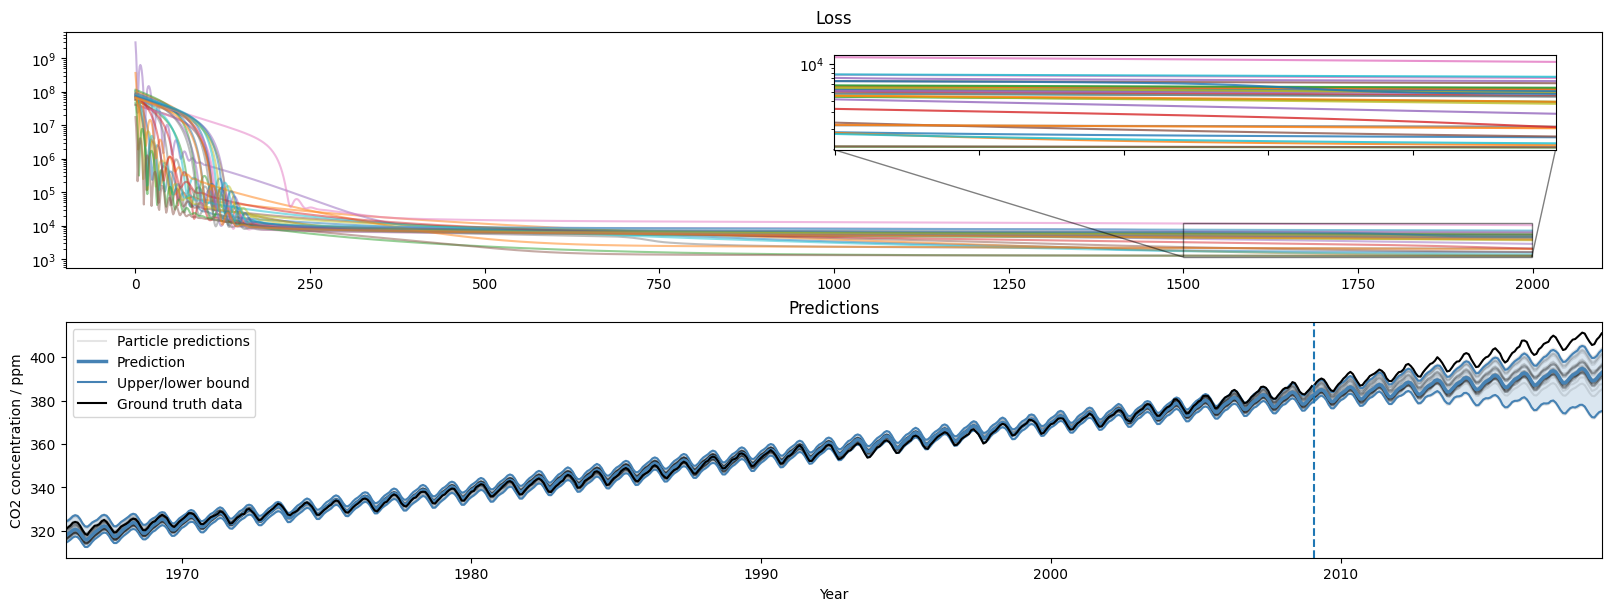

In [ ]:
preds = jax.vmap(lambda p: kernel.apply(p, x_test[..., None]))(params)

draws = likelihood.sample(params['params'], preds.squeeze(), seed=pred_seed, sample_shape=100)
lo, mid, p90, hi = jnp.percentile(draws.squeeze(), jnp.array([2.5, 50., 90., 97.5]), axis=(0, 1))

plot = training_util.plot_results(co2_dates,
                               preds,
                               dates_test=co2_dates[-num_forecast_steps:],
                               y_test=co2_by_month[-num_forecast_steps:],
                               p2_5=lo,
                               p50=mid,
                               p97_5=hi,
                               dates_train=co2_dates[:-num_forecast_steps],
                               y_train=co2_by_month[:-num_forecast_steps],
                               diagnostics=loss,
                               log_scale=True,
                               show_particles=True,
                               left_limit=50*12,
                               right_limit=10*12)

plot.axes[1].set_xlabel("Year")
plot.axes[1].set_ylabel("CO2 concentration / ppm")

Метрика
Фрейм make_results_dataframe предоставляет SMAPE, MASE и MSIS, общие показатели прогнозирования, для этого соответствия. Мы вычисляем показатели с точностью до 10 лет (заданные параметром num_forecast_steps) и сообщаем о соответствии по истечении 60 месяцев (т.е. 5 лет) в качестве примера.

In [ ]:
training_util.make_results_dataframe(mid[-num_forecast_steps:],
                                     y_test=co2_by_month[-num_forecast_steps:],
                                     y_train=co2_by_month[:-num_forecast_steps],
                                     p2_5=lo[-num_forecast_steps:],
                                     p90=p90[-num_forecast_steps:],
                                     p97_5=hi[-num_forecast_steps:]
                                     ).iloc[60]

yhat          388.255524
yhat_lower    381.969788
p90           393.649658
yhat_upper    395.399536
y             398.100006
smape           1.895603
mase            4.827249
msis           51.246124
Name: 60, dtype: float64

Обнаружение структуры с помощью непрерывных изменений
Ручное задание ядра, как мы делали выше, может быть полезно во многих ситуациях. Однако истинная сила платформы AutoBNN заключается в ее способности обнаруживать структуру непосредственно из данных. Ниже мы запускаем тот же инструмент оценки КАРТЫ с моделью sum_of_products, которая является одним из семейств моделей, распространяемых вместе с пакетами AutoBNN.

Это ядро использует непрерывную релаксацию по периодическим, линейным, возведенным в степень квадратичным, многочленам второй степени и единичным листьям в качестве базовой структуры. Затем оно объединяет четыре таких поддерева, сначала добавляя их попарно, а затем перемножая последние два поддерева. Это структура, которую мы эмпирически нашли подходящей для моделирования широкого спектра временных рядов. Она может послужить полезной отправной точкой для дальнейшего изучения. Другие семейства моделей, поддерживающие обнаружение структуры, можно найти в файле models.py.

In [ ]:
%%time
fit_seed, pred_seed, seed = jax.random.split(seed, 3)

est = estimators.AutoBnnMapEstimator(
    'sum_of_products',
    likelihood_model='normal_likelihood_logistic_noise',
    seed=jax.random.PRNGKey(0),
    periods=(one_year,),
    num_particles=32,
)

est = est.fit(x_train[..., None], y_train[..., None])

CPU times: user 22.3 s, sys: 5.78 s, total: 28.1 s
Wall time: 28.6 s


Визуализируем результаты работы модели AutoBNN
По сравнению с описанным выше ядром, созданным вручную, график прогнозирования показывает более точное соответствие обучающим данным с постепенным увеличением неопределенности по мере приближения к горизонту прогноза.

Text(24.000000000000007, 0.5, 'CO2 concentration / ppm')

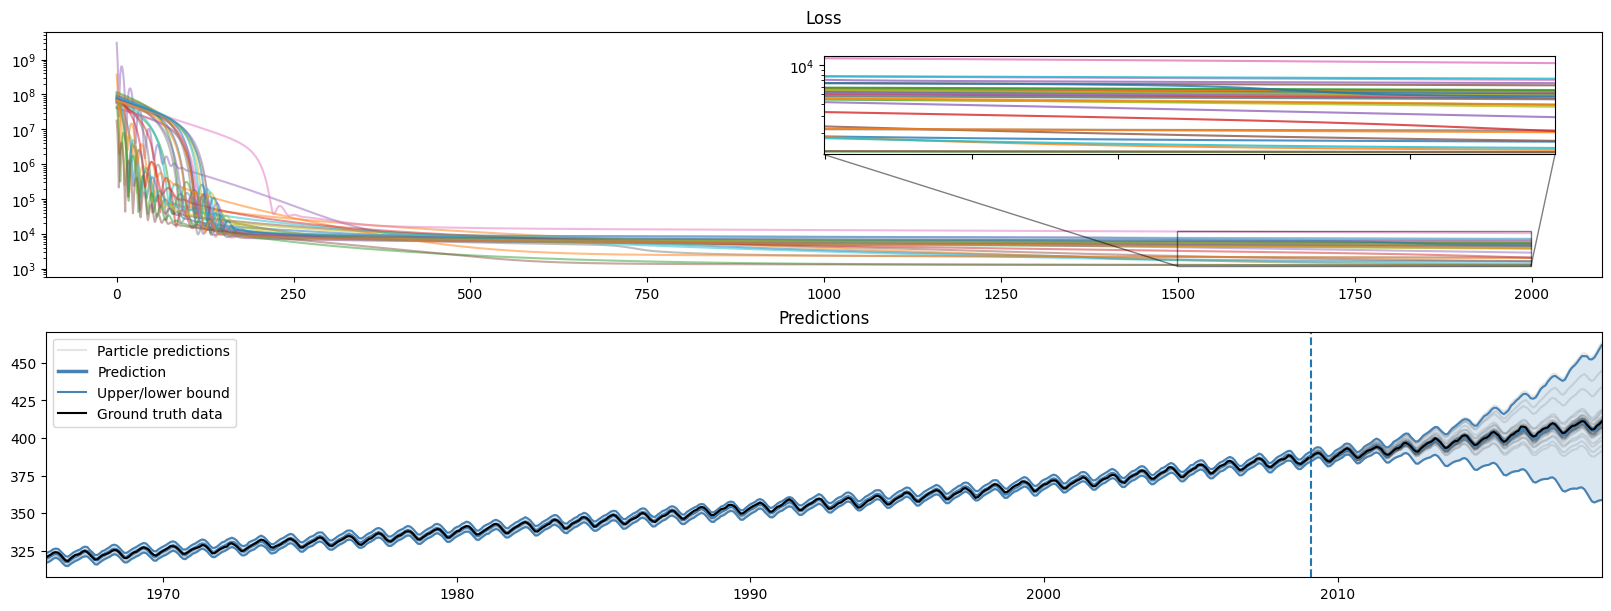

In [ ]:
preds = est.predict(x_test[..., None])
lo, mid, p90, hi = est.predict_quantiles(x_test[..., None], q=[2.5, 50., 90., 97.5])
_ = training_util.plot_results(co2_dates,
                               preds,
                               dates_test=co2_dates[-num_forecast_steps:],
                               y_test=co2_by_month[-num_forecast_steps:],
                               p2_5=lo,
                               p50=mid,
                               p97_5=hi,
                               dates_train=co2_dates[:-num_forecast_steps],
                               y_train=co2_by_month[:-num_forecast_steps],
                               diagnostics=loss,
                               log_scale=True,
                               show_particles=True,
                               left_limit=50*12,
                               right_limit=10*12)
plot.axes[1].set_xlabel("Year")
plot.axes[1].set_ylabel("CO2 concentration / ppm")

In [ ]:


training_util.make_results_dataframe(mid[-num_forecast_steps:],


     y_test=co2_by_month[-num_forecast_steps:],
                                     y_train=co2_by_month[:-num_forecast_steps],
                                     p2_5=lo[-num_forecast_steps:],
                                     p90=p90[-num_forecast_steps:],
                                     p97_5=hi[-num_forecast_steps:]
                                     ).iloc[60]

yhat          398.328735
yhat_lower    384.919556
p90           404.988708
yhat_upper    409.113342
y             398.100006
smape           0.084582
mase            0.217604
msis            7.743238
Name: 60, dtype: float64

Вывод
В этом коллаборации демонстрируются два приложения платформы AutoBNN к набору данных Mauna Loa: подгонка модели с заранее определенной структурой и использование structure discovery. Хотя этот набор данных с примерно 500 временными шагами вполне подходит для настройки GP, мы успешно запустили те же модели с наборами данных с 5000 и более временными шагами.

In [ ]:
import autobnn as ab

model = ab.operators.Add(
    bnns=(ab.kernels.PeriodicBNN(width=50),
          ab.kernels.LinearBNN(width=50),
          ab.kernels.MaternBNN(width=50)))

estimator = ab.estimators.AutoBnnMapEstimator(
    model, 'normal_likelihood_logistic_noise', jax.random.PRNGKey(42),
    periods=[12])

estimator.fit(my_training_data_xs, my_training_data_ys)
low, mid, high = estimator.predict_quantiles(my_training_data_xs)

NameError: name 'my_training_data_xs' is not defined